In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import datatable as dt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from wordcloud import WordCloud
plt.rcParams['figure.figsize'] = (15, 9)

In [3]:
import os
os.chdir('..')
from finlang.nlp_utils import tagging_utils as tu

In [4]:
data = dt.fread(file='full_comments_cleaned.csv').to_pandas()
data['created_utc'] = data['created_utc'].astype('datetime64')
data['retrieved_on'] = data['retrieved_on'].astype('datetime64')

In [5]:
data['day'] = data['created_utc'].dt.date
len_data = data.groupby(['subreddit', 'day']).apply(len).reset_index()
len_data.rename({0: 'len'}, axis=1, inplace=True)

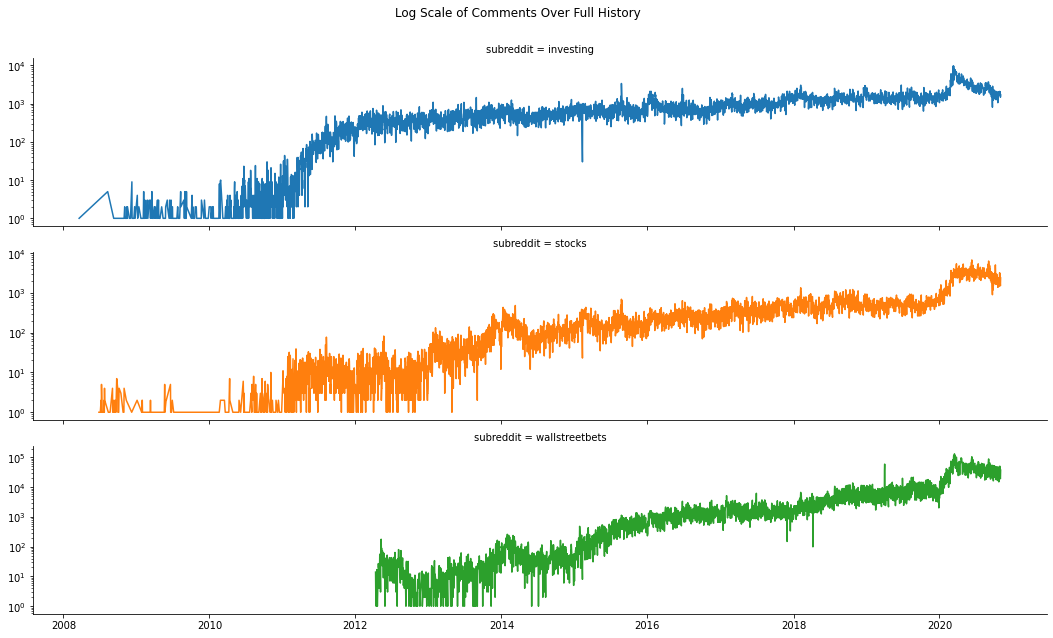

In [6]:
plt.rcParams['figure.figsize'] = (15, 12)
g = sns.FacetGrid(data=len_data, row='subreddit', hue='subreddit', aspect=5, sharey=False)
g.map_dataframe(sns.lineplot, x='day', y='len')
g.set(yscale='log')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Log Scale of Comments Over Full History')
plt.show()

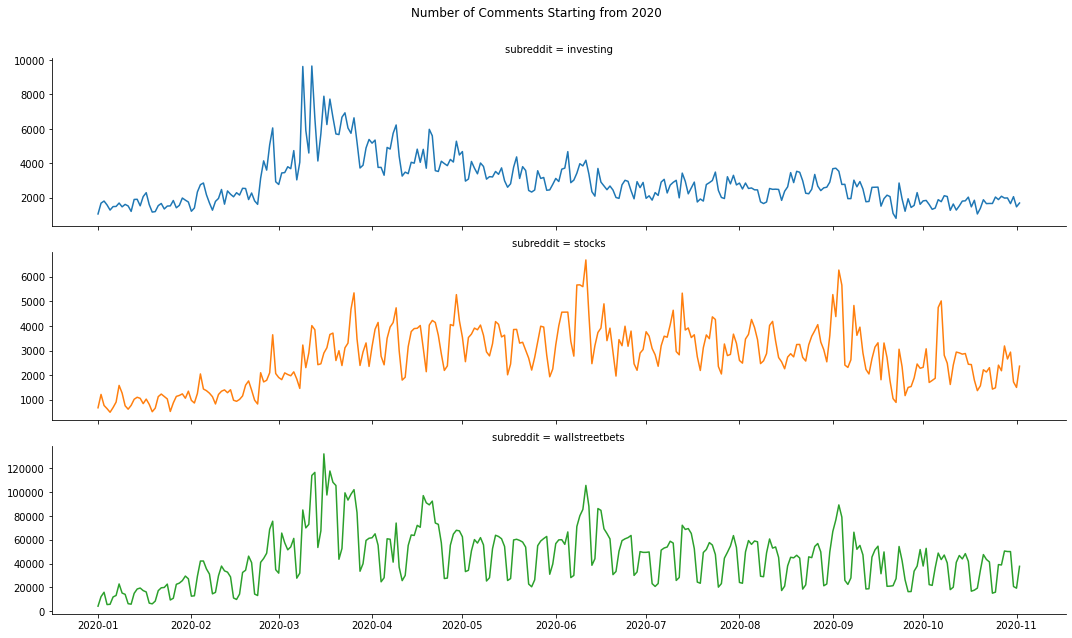

In [7]:
g = sns.FacetGrid(data=len_data[len_data['day'] >= datetime.date(2020, 1, 1)], row='subreddit', hue='subreddit', aspect=5, sharey=False)
g.map_dataframe(sns.lineplot, x='day', y='len')
plt.subplots_adjust(top=0.9)
g.fig.suptitle('Number of Comments Starting from 2020')
plt.show()

In [8]:
keyword_tagger = tu.tagging_pipeline('keywords')
tickers = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]['Symbol'].unique().tolist()
data = keyword_tagger(data, tickers, 'body')

100%|██████████| 25166203/25166203 [11:40<00:00, 35921.05it/s] 


In [9]:
data = data[data['body_keywords'].astype(bool)]
data.shape

(5575067, 8)

In [10]:
data['body_keywords'].apply(len).sum()

9731552

In [11]:
from collections import defaultdict
adj_keywords = tu.expanded_list_linking_index(data, 'body_keywords')

5575067it [07:11, 12929.45it/s]


In [32]:
samp = data.sample(1000)
samp['label'] = (np.random.rand(samp.shape[0]) < 0).astype(int)

In [22]:
data['body_sentiment'] = (np.random.randn(data.shape[0]) < 0.5).astype(np.int8) * 2 - 1

In [23]:
from judgement.plotting import plotting_utils as pu

In [56]:
data['subreddit'] = 'r/' + data['subreddit'] 

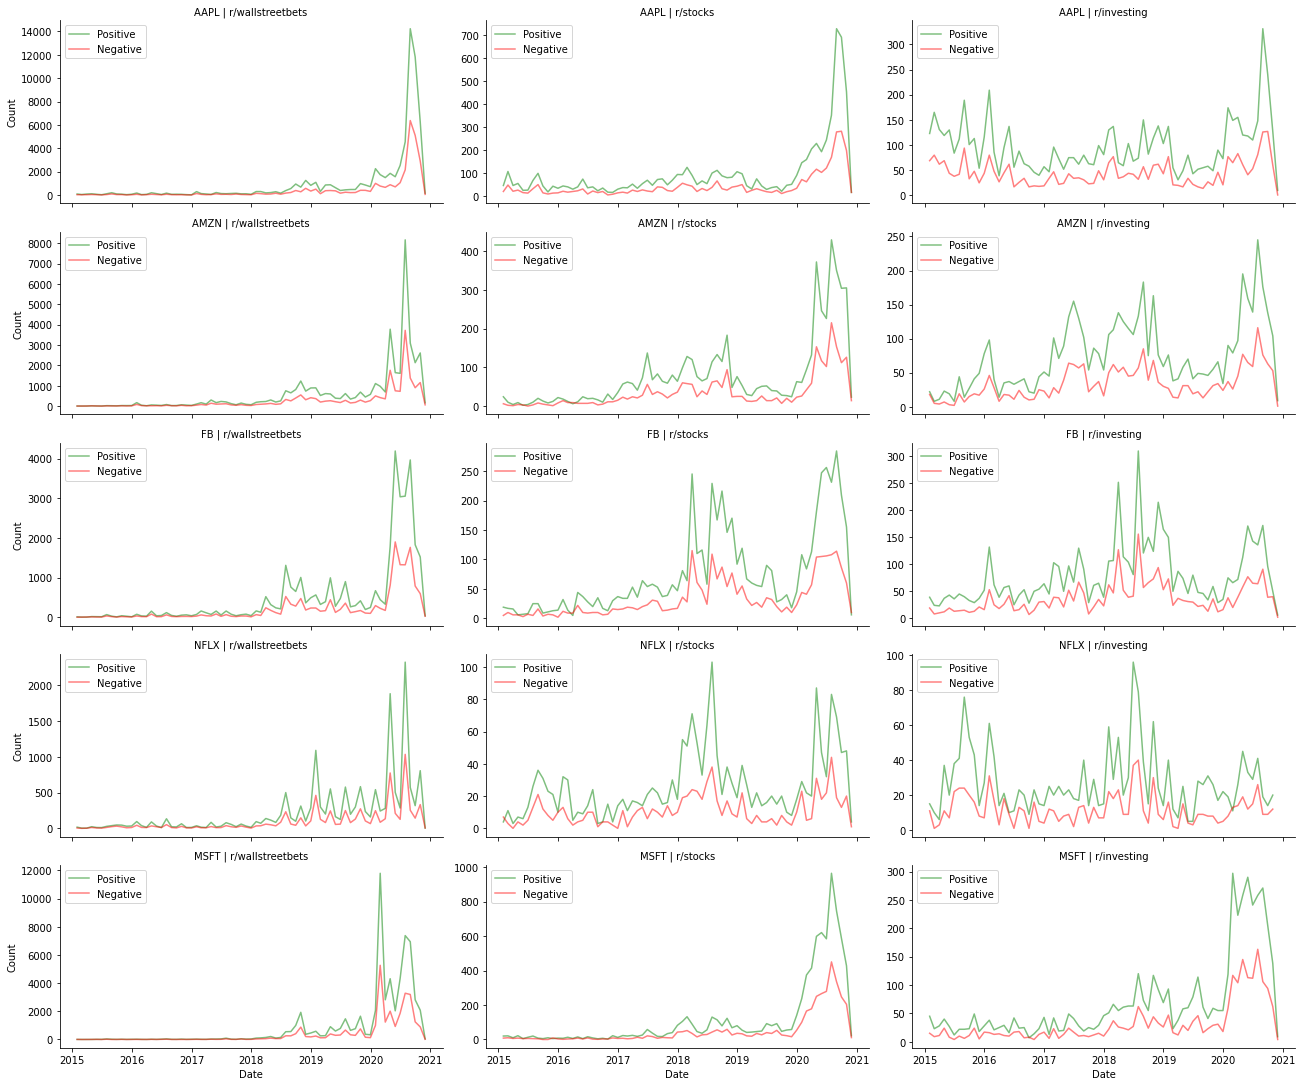

In [64]:
fig, ax = pu.plot_keywords(
    data, adj_keywords,
    'created_utc', 'subreddit', 'body_sentiment',
    datetime.datetime(2015, 1, 1), datetime.datetime.today(),
    ['r/wallstreetbets', 'r/stocks', 'r/investing'],
    ['AAPL', 'AMZN', 'FB', 'NFLX', 'MSFT'],
    'm', 'count', True, True, False
)

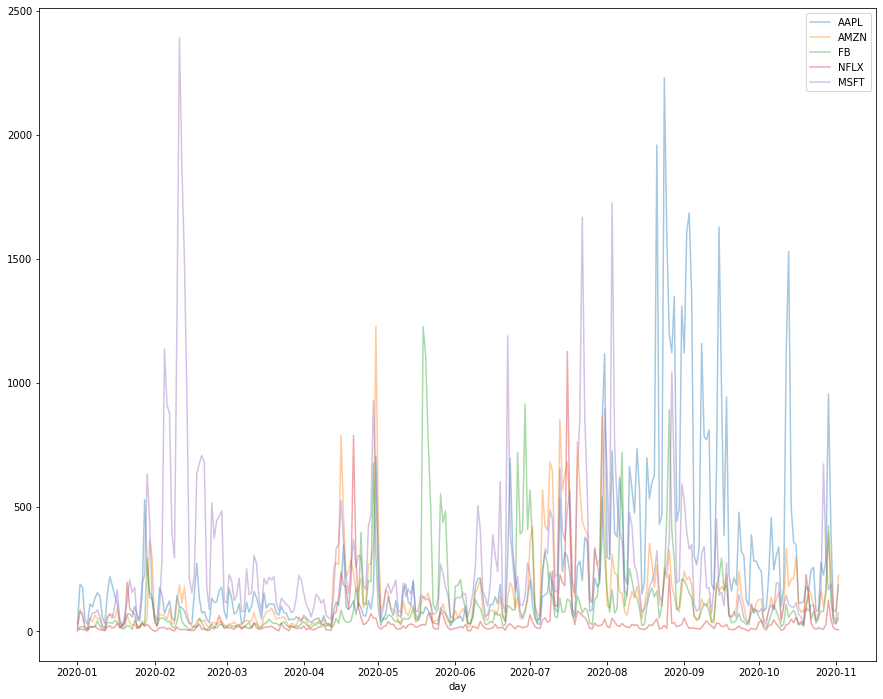

In [60]:
fig, ax = plt.subplots(1)
for tick in ['AAPL', 'AMZN', 'FB', 'NFLX', 'MSFT']:
    temp = adj_keywords[tick].intersection(set(foo.index))
    foo.loc[temp].groupby('day').apply(len).plot(ax=ax, alpha=.4, label=tick, legend=True)
plt.show()

In [20]:
def _expand_list_column(df, col):
    expanded = df[col].apply(pd.Series).reset_index().melt(
        id_vars='index', value_name=col
    ).dropna()[['index', col]].set_index('index')
    df = expanded.merge(df.loc[:, df.columns != col], left_index=True, right_index=True)
    return df

def _expanded_linking_table(df, col):
    return df[col].apply(lambda x: pd.Series(x, index=x.index))